# TOC

__Chapter 07 - Feature learning__

1. [Import](#Import)
1. [Parametric assumptions of data](#Parametric-assumptions-of-data)
1. [Restricted Boltzmann Machines](#Restricted-Boltzmann-Machines)
    1. [BernoulliRBM](#BernoulliRBM)
    1. [Extracting PCA components from MNIST](#Extracting-PCA-components-from-MNIST)
    1. [Extracting RBM components from MNIST](#Extracting-RBM-components-from-MNIST)
    1. [Using RBMs in a machine learning pipeline](#Using-RBMs-in-a-machine-learning-pipeline)
        1. [Using a linear model on raw pixel values](#Using-a-linear-model-on-raw-pixel-values)
        1. [Using a linear model on extracted PCA components](#Using-a-linear-model-on-extracted-PCA-components)
        1. [Using a linear model on extracted RBM components](#Using-a-linear-model-on-extracted-RBM-components)

# Import

<a id = 'Import'></a>

In [1]:
# standard libary and settings
import os
import sys
import importlib
import itertools
import warnings

warnings.simplefilter("ignore")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))

# data extensions and settings
import numpy as np

np.set_printoptions(threshold=np.inf, suppress=True)
import pandas as pd

pd.set_option("display.max_rows", 500)
pd.options.display.float_format = "{:,.6f}".format

# modeling extensions
import sklearn.neural_network as neural_network
import sklearn.preprocessing as preprocessing
import sklearn.pipeline as pipeline
import sklearn.neighbors as neighbors
import sklearn.model_selection as model_selection
import sklearn.decomposition as decomposition
import sklearn.linear_model as linear_model

# visualization extensions and settings
import seaborn as sns
import matplotlib.pyplot as plt

# custom extensions and settings
sys.path.append("/home/mlmachine") if "/home/mlmachine" not in sys.path else None
sys.path.append("/home/prettierplot") if "/home/prettierplot" not in sys.path else None

import mlmachine as mlm
from prettierplot.plotter import PrettierPlot
import prettierplot.style as style

# magic functions
%matplotlib inline

# Parametric assumptions of data

Feature learning algorithms remove the parametric assumption of data that PCA and LDA make. Rather than making assumptions about the shape of the data, these feature learning techniques rely on stochastic learning - that is, an iterative process is performed on the data rather than a well-defined linear transformation.

That being said, non-parametric techniques that will be discussed here still make assumptions about the data, just not the shape. Here are some examples of non-parametric feature extraction techniques:

- Restricted Boltzmann Machine (RBM)
- Word embeddings

<a id = 'Parametric-assumptions-of-data'></a>

# Restricted Boltzmann Machines

RBMs are a family of unsupervised feature learning algorithms that use probabilistic models to learn new features. Just as with PCA and LDA, RBMs extract new features from raw data. These new features tend to work best when followed by linear models.

Conceptually, RBMs can be thought of as shallow neural networks, having only two layers. It is an unsupervised method, so there is only a visible layer and a hidden layer. The (first) visible layer contains as many nodes as there are input features. The number of nodes in the hidden layer is a parameter chosen by the user, and represents the number of features we wish to learn. There is theoretically no limit to the number of features that RBMs can learn - this number can be fewer than the number of features we start with, and can also be more than the number of features we start with.

Each node in the the visible layer is connected to each node in the hidden layer, and these connections have a weight. The dot product of the input values and the weights (plus bias) generates a value that is pass into an activation function.

The 'Restriction' aspect of RBMs means there aren't any connections between nodes in the same layer. This allows for nodes to independently create weights and end up being independent features.

After one forward pass is completed, the direction of information flow reverses. The previously activated values are the input values and are multiplied by the same weights, but new biases, that connect the hidden layer nodes to all nodes in the visible layer. This backwards pass is effectively an approximation of the original input. After one full forward/backward cycle, the weights are adjusted with the intention of minimizing the distance between the original input and the approximations. This process is repeated for many iterarions, and in this process the network is trying to obtain an approximation of the original input.

As an example, suppose we are trying to pass in a grid of pixels representing a digit between 0 and 9. We pass in the pixels with the question, "What digit is this?". On the reverse pass, we are in a way passing in a digit and asking "What pixels should I expect?" More formally, this is a joint probability, which is the simultaneous probability of y given x and x given y

<a id = 'Restricted-Boltzmann-Machines'></a>

In [2]:
# # load data
# dataPath = "..\\PythonMachineLearning2ndEd"
# XData, yData = load_mnist(path=os.path.join(dataPath, "MNISTDigits"), kind="train")
# print("Rows: {}, columns: {}".format(XData.shape[0], XData.shape[1]))

# XTest, yTest = load_mnist(path=os.path.join(dataPath, "MNISTDigits"), kind="t10k")
# print("Rows: {}, columns: {}".format(XTest.shape[0], XTest.shape[1]))

In [3]:
# Load data and print dimensions
dfTrain = pd.read_csv("../../data/kaggleMNIST/train.csv", sep=",")
dfTest = pd.read_csv("../../data/kaggleMNIST/test.csv", sep=",")

# separate
dfTrainLabel = dfTrain["label"]
dfTrain = dfTrain.drop(labels="label", axis=1).values

# train/test split
XTrain, XValid, yTrain, yValid = model_selection.train_test_split(
    dfTrain, dfTrainLabel, test_size=0.2
)

print('XTrain shape: {}'.format(XTrain.shape))
print('yTrain shape: {}'.format(yTrain.shape))
print('')
print('XValid shape: {}'.format(XValid.shape))
print('yValid shape: {}'.format(yValid.shape))

print("Training data dimensions: {}".format(dfTrain.shape))
print("Test data dimensions: {}".format(dfTest.shape))



XTrain shape: (33600, 784)
yTrain shape: (33600,)

XValid shape: (8400, 784)
yValid shape: (8400,)
Training data dimensions: (42000, 784)
Test data dimensions: (28000, 784)


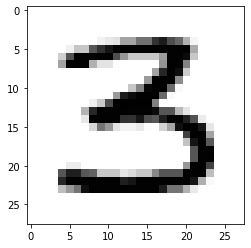

In [4]:
# sample
plt.imshow(XTrain[0].reshape(28, 28), cmap=plt.cm.gray_r)

## BernoulliRBM

The only scikit-learn implemented RBM is the BernoulliRBM module. It allows for values between zero and one because the node values represent a probability that the node is activated or not, which allows for quicker learning of feature sets. To preprocess the data, we need to:

- Scale the values of pixels to values between zero and one
- Change the pixel values in place to be true if the value is over 0.5, and false otherwise.

<a id = 'BernoulliRBM'></a>

In [5]:
# scale to 0 and 1
XTrain = XTrain / 255.0
XTrain = (XTrain > 0.5).astype(float)
np.min(XTrain), np.max(XTrain)

(0.0, 1.0)

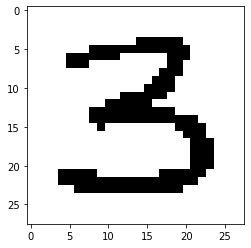

In [6]:
# visualize sample
plt.imshow(XTrain[0].reshape(28, 28), cmap=plt.cm.gray_r)

> Remarks - Note that this image is less fuzzy than the output above.

## Extracting PCA components from MNIST

Before applying the RBM approach, we will first apply PCA to the image dataset. The intent is to approach is to take the features (784 on/off pixels) and apply an eigenvalue decomposition to the matrix to extract the eigendigits.

We will plot the first 100 components from the possible 784

<a id = 'Extracting-PCA-components-from-MNIST'></a>

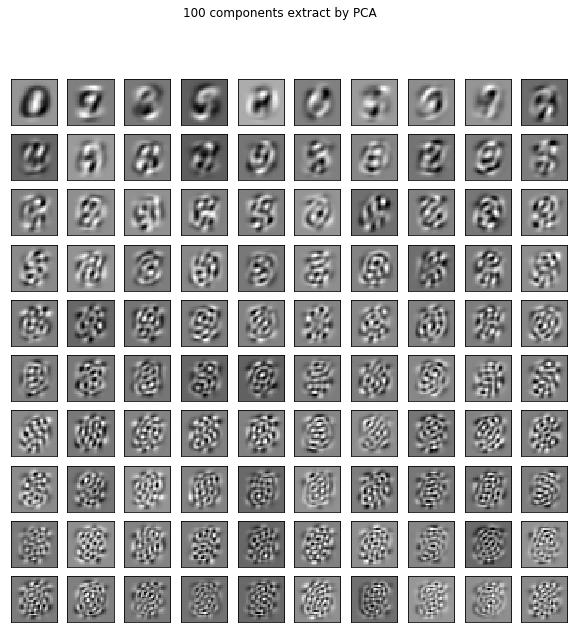

In [7]:
# use PCA to extract top 100 components
pca = decomposition.PCA(n_components=100)
pca.fit(XTrain)

plt.figure(figsize=(10, 10))

# visualize components
for i, comp in enumerate(pca.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.gray_r)
    plt.xticks(())
    plt.yticks(())
    plt.suptitle("100 components extract by PCA")

plt.show()

> Remarks - This gallery of images displays what the eigenvalues of the covariance matrix look like when reshaped to the same dimensions as the original images. This is what extracted components of this dataset look like as PCA attempts to identify important features, as the algorithm attempts to understand a certain "aspect" of the iamges that will translate into interpretable knowledge.

> Looking at the first component, it's pretty clear that PCA puts high value on searching for a 0-like shape in an observation. In the second and third componenets, there is a faint appearance of a 9 and 8, respectively. Beyond that, the components get look progressively less like digits and more like random assortments of black and white pixels.

In [8]:
# variance captured by first 30 components
pca.explained_variance_ratio_[:30].sum()

0.6309052316231935

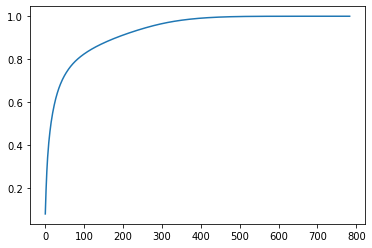

In [9]:
# visualize cumulative explained variance
full_pca = decomposition.PCA(n_components=784)
full_pca.fit(XTrain)

plt.plot(np.cumsum(full_pca.explained_variance_ratio_))

> Remarks - The first 30 components capture nearly 2/3's of the variance, and the variance capture by subsequent components is quite small.

## Extracting RBM components from MNIST

<a id = 'Extracting-RBM-components-from-MNIST'></a>

In [10]:
# extract top 100 componenets using BernoulliRBM
import sklearn.neural_network as neural_network

rbm = neural_network.BernoulliRBM(
    random_state=0, verbose=True, n_iter=20, n_components=100
)
rbm.fit(XTrain)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -111.64, time = 5.36s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -113.09, time = 5.76s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -122.61, time = 6.03s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -104.17, time = 6.04s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -107.83, time = 6.53s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -106.63, time = 5.55s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -106.25, time = 5.96s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -103.85, time = 5.54s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -112.50, time = 5.52s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -104.99, time = 5.74s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -105.65, time = 5.86s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -105.68, time = 5.58s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -110.25, time = 5.52s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -103.63, time = 6.03s
[BernoulliRBM] 

BernoulliRBM(batch_size=10, learning_rate=0.1, n_components=100, n_iter=20,
             random_state=0, verbose=True)

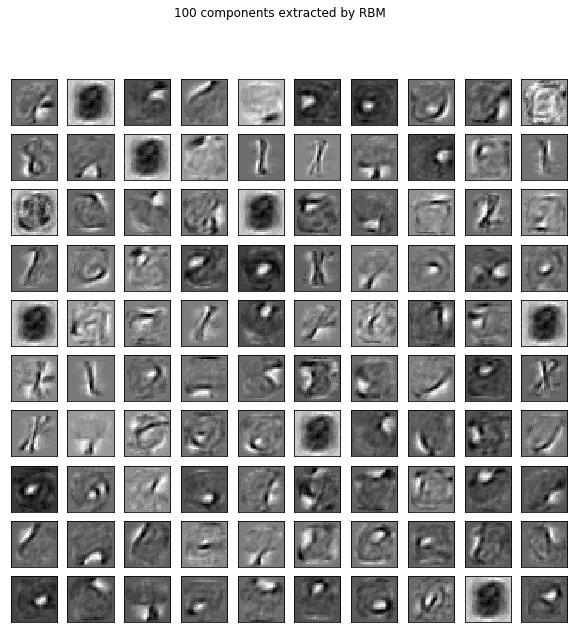

In [11]:
# visualize RBM components
plt.figure(figsize=(10, 10))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.gray_r)
    plt.xticks(())
    plt.yticks(())
    plt.suptitle("100 components extracted by RBM")

plt.show()

> Remarks - While the PCA components became distorted very quickly, the RBM components appear to extracted various shape, and even apparent pen strokes, in each component. 

In [12]:
# some components look to be repeated, but are likely similar but still unique
print(np.unique(rbm.components_.mean(axis=1)).shape)

(100,)


In [13]:
# capture new features for first observation, a number 5
image_new_features = rbm.transform(XTrain[:1]).reshape(100)
image_new_features

array([0.        , 1.        , 0.        , 0.        , 0.99999344,
       0.        , 0.97847213, 0.        , 0.        , 0.99999813,
       0.        , 0.        , 1.        , 0.99999999, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.99996676, 0.99999999, 0.        ,
       0.        , 0.        , 0.99999978, 0.        , 0.        ,
       0.99999999, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.97343612, 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.99643485, 0.00015939, 0.        , 0.99999937, 0.        ,
       0.        , 0.        , 0.0000672 , 0.        , 0.00000016,
       0.99999985, 0.99998844, 0.        , 0.99999998, 0.        ,
       0.        , 0.00000018, 0.        , 1.        , 0.     

In [14]:
# print top 20 features for the first observation
top_features = image_new_features.argsort()[-20:][::-1]
print(top_features)
print(image_new_features[top_features])

[93 96  1 49 24 73 12 95 40 13 33 98 68 65 37 58  9  4 66 32]
[1.         1.         1.         1.         1.         1.
 1.         1.         0.99999999 0.99999999 0.99999999 0.99999999
 0.99999998 0.99999985 0.99999978 0.99999937 0.99999813 0.99999344
 0.99998844 0.99996676]


> Remarks - There are 7 features in which the RBM has a full 100%. That means that passing in the 784 pixels for the first observations into the visible layer of the RBM lights up the nodes 63, 69, 14, 18, 62, 66, and 21 at full capacity. This speaks to the nodes perception that these pixels represent a 5.

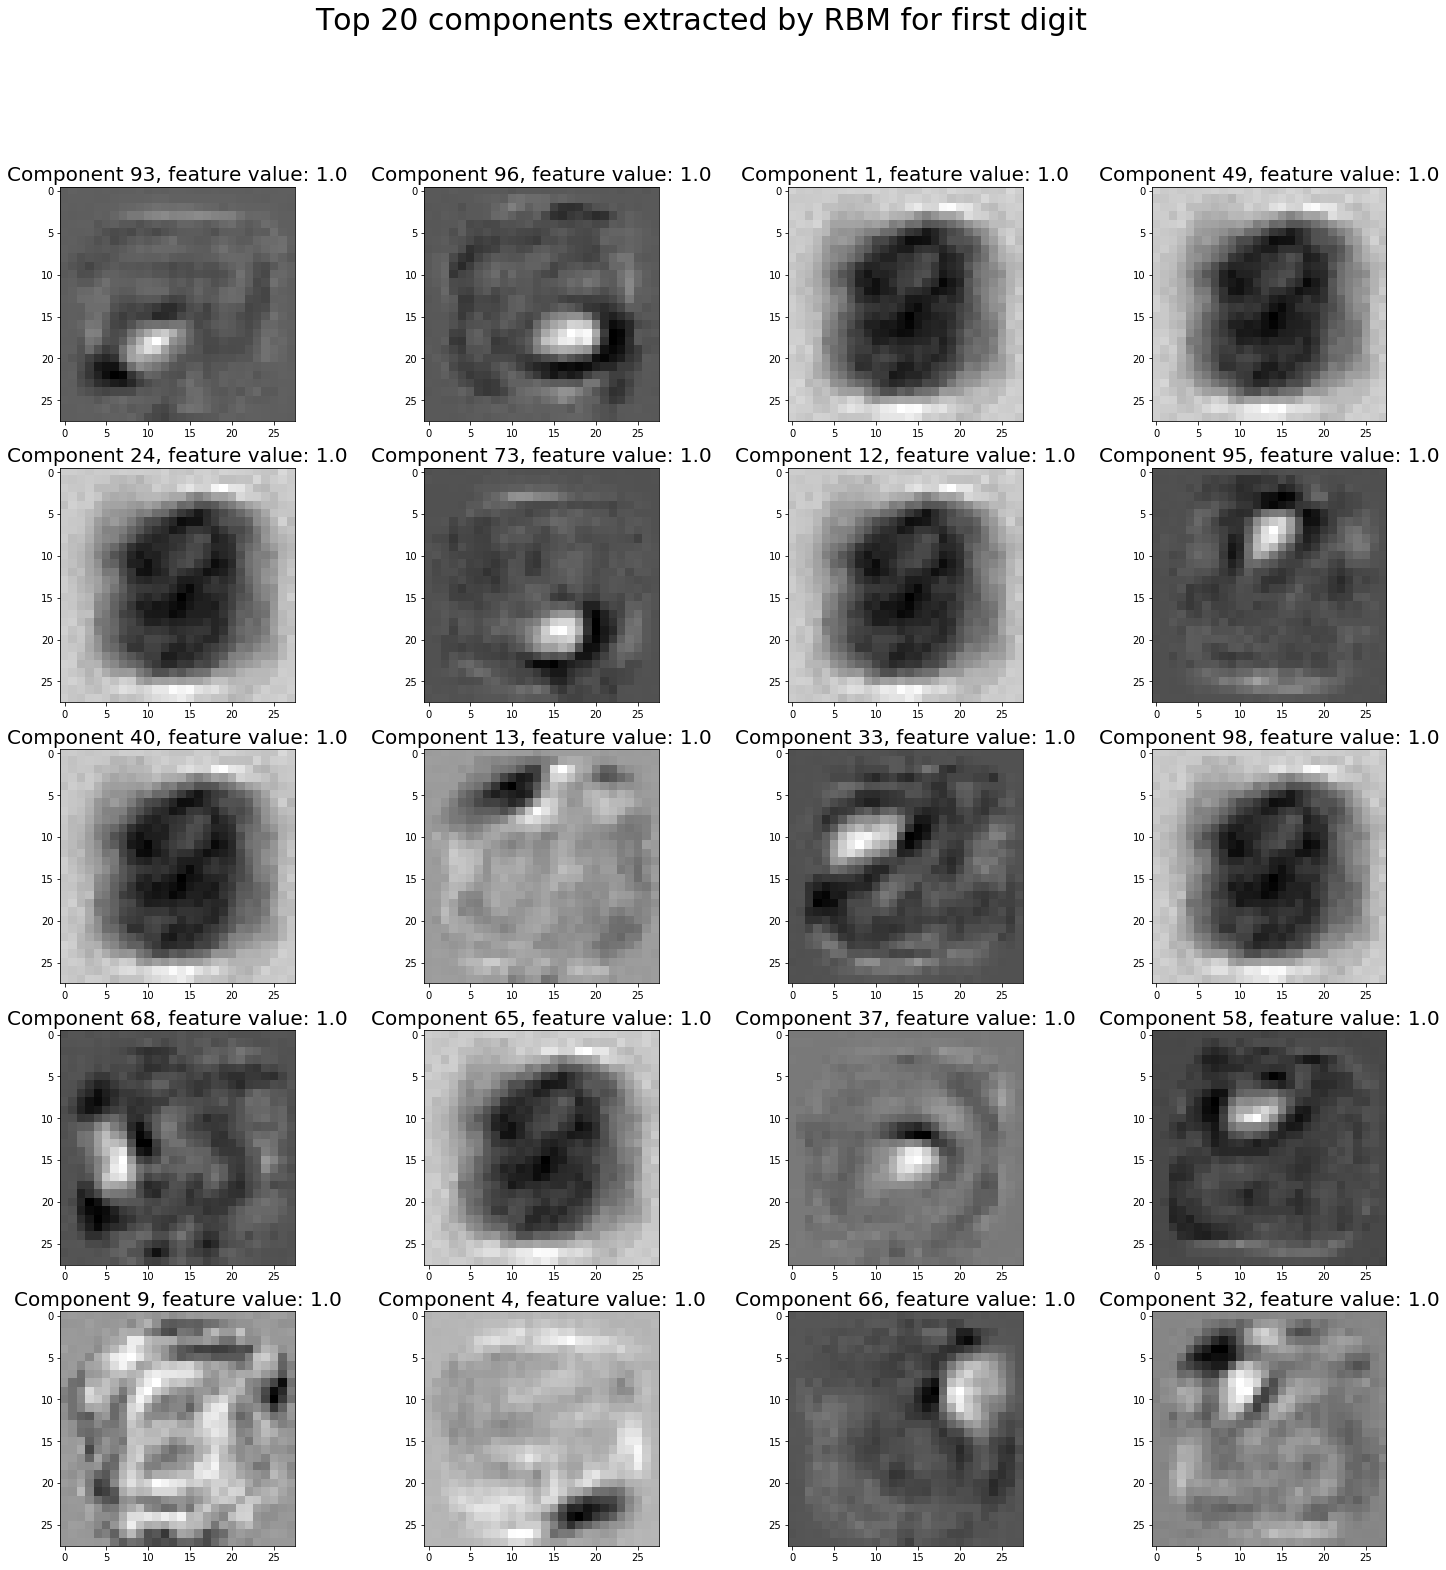

In [15]:
# plot top 20 RBM components for the first observation, a number 5
plt.figure(figsize=(25, 25))
for i, comp in enumerate(top_features):
    plt.subplot(5, 4, i + 1)
    plt.imshow(rbm.components_[comp].reshape((28, 28)), cmap=plt.cm.gray_r)
    plt.title(
        "Component {}, feature value: {}".format(
            comp, round(image_new_features[comp], 2)
        ),
        fontsize=20,
    )
    plt.suptitle("Top 20 components extracted by RBM for first digit", fontsize=30)

plt.show()

> Remarks - In several of the component, a faint outline of key characteristics of the number 5 are visible.

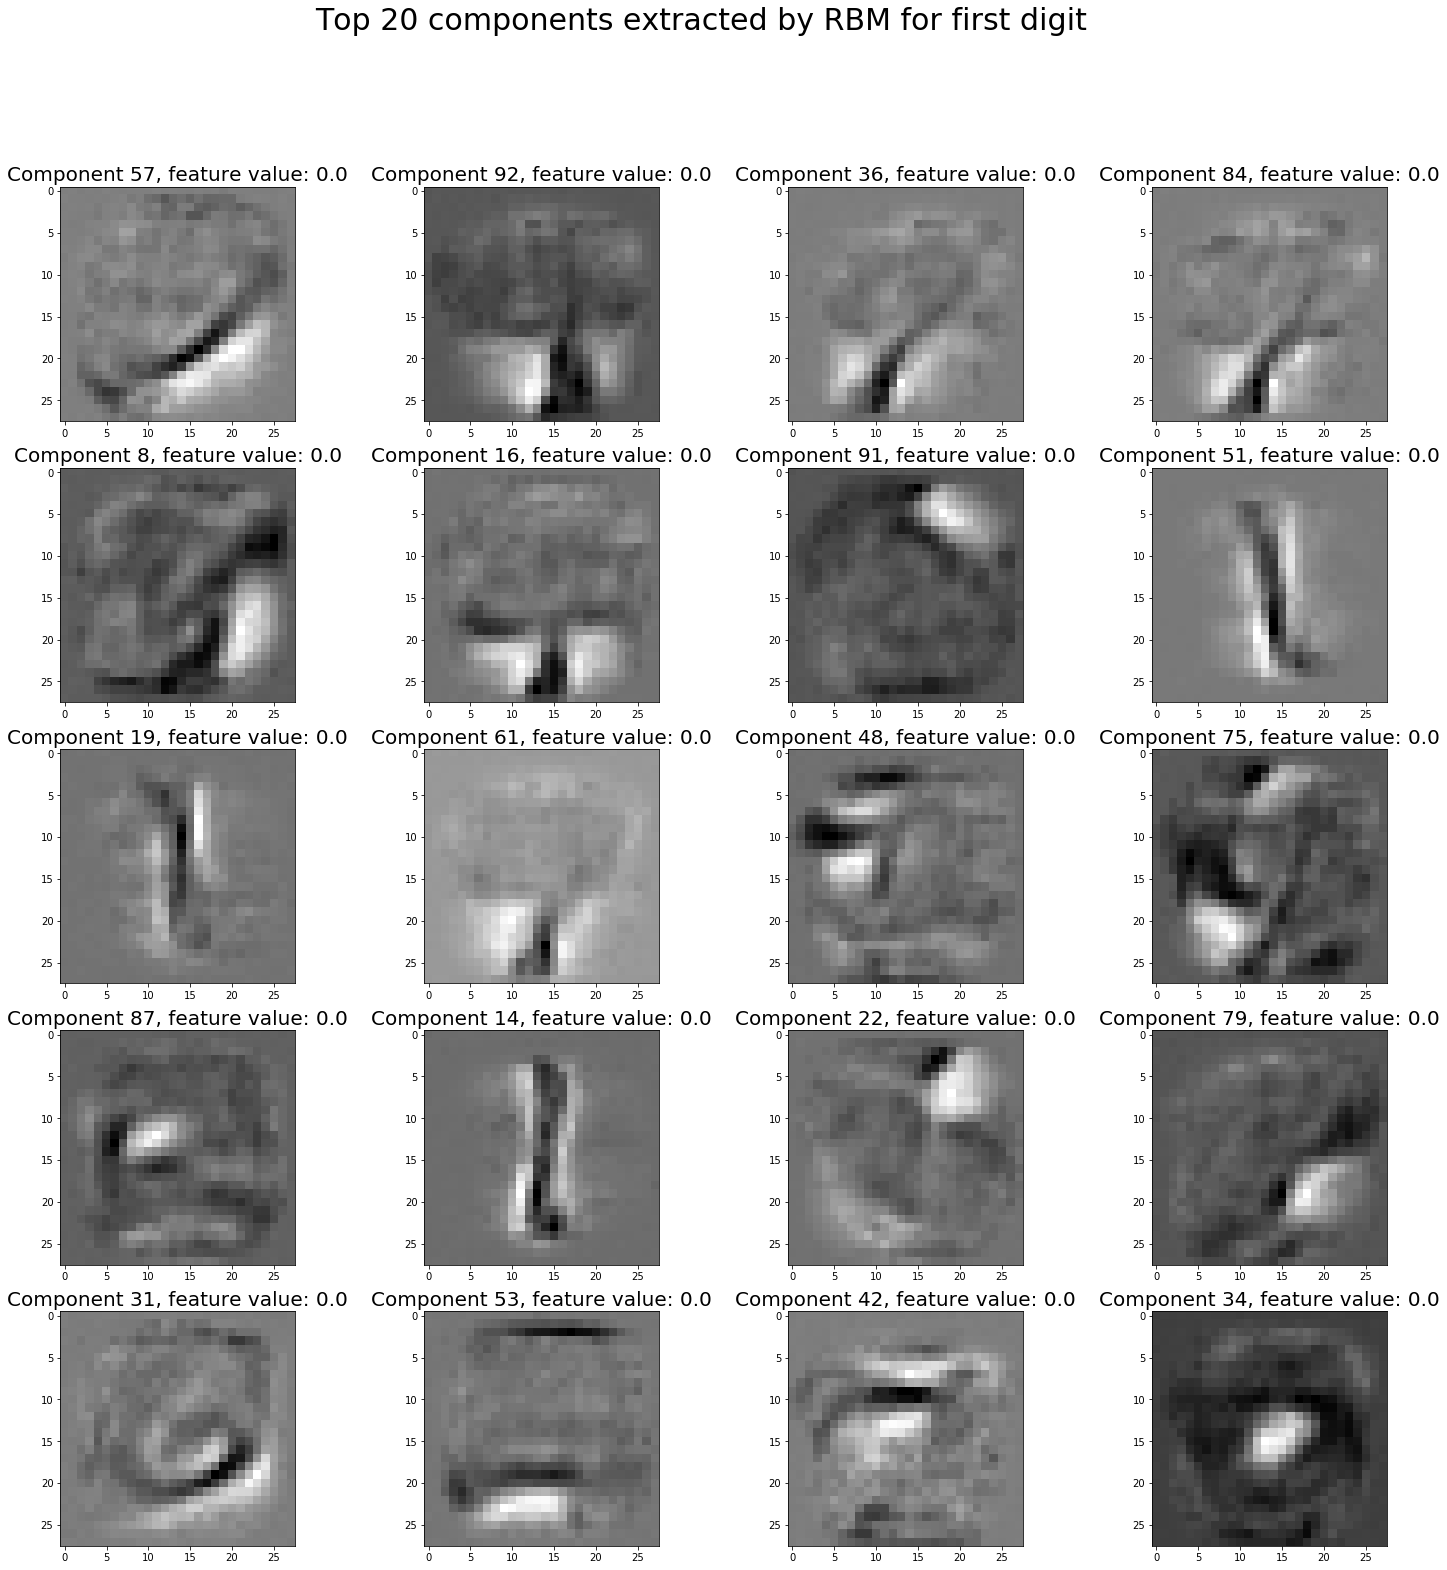

In [16]:
# plot bottom 20 RBM components for the first observation, a number 5
bottom_features = image_new_features.argsort()[:20]

plt.figure(figsize=(25, 25))
for i, comp in enumerate(bottom_features):
    plt.subplot(5, 4, i + 1)
    plt.imshow(rbm.components_[comp].reshape((28, 28)), cmap=plt.cm.gray_r)
    plt.title(
        "Component {}, feature value: {}".format(
            comp, round(image_new_features[comp], 2)
        ),
        fontsize=20,
    )
    plt.suptitle("Top 20 components extracted by RBM for first digit", fontsize=30)

plt.show()

> Remarks - For these bottom 20 components (those that are least associated with the number 5, we can see distinct outlines of several other digits, such as 1, 8 and 6.

## Using RBMs in a machine learning pipeline

<a id = 'Using-RBMs-in-a-machine-learning-pipeline'></a>

### Using a linear model on raw pixel values

<a id = 'Using-a-linear-model-on-raw-pixel-values'></a>

In [17]:
# basic logistic regression grid search
lr = linear_model.LogisticRegression()
params = {"C": [1e-2, 1e-1, 1e0, 1e1, 1e2]}

grid = model_selection.GridSearchCV(lr, params)

grid.fit(XTrain, yTrain)
print(grid.best_params_, grid.best_score_)

{'C': 0.1} 0.9046130952380952


> Remarks - Logistic regression achieves a cross-validated accuracy of 90.61% on the raw pixel values. We will regard this is our baseline performance.

### Using a linear model on extracted PCA components

<a id = 'Using-a-linear-model-on-extracted-PCA-components'></a>

In [18]:
# use PCA to extract new features
lr = linear_model.LogisticRegression()
pca = decomposition.PCA()

# set the params for the pipeline
params = {"clf__C": [1e-1, 1e0, 1e1], "pca__n_components": [10, 100, 200]}

# create pipeline
pipe = pipeline.Pipeline([("pca", pca), ("clf", lr)])

# instantiate a gridsearh class
grid = model_selection.GridSearchCV(pipe, params)

# fit to our data
grid.fit(XTrain, yTrain)

# check the best params
print(grid.best_params_, grid.best_score_)

{'clf__C': 1.0, 'pca__n_components': 200} 0.903779761904762


> Remarks - Inserting PCA into the pipeline did not increase the cross-validated accuracy score compared to the baseline.

### Using a linear model on extracted RBM components

<a id = 'Using-a-linear-model-on-extracted-RBM-components'></a>

In [19]:
# use the RBM to learn new features
lr = linear_model.LogisticRegression()
rbm = neural_network.BernoulliRBM(random_state=0)

# set up the params for our pipeline.
params = {"clf__C": [1e-1, 1e0, 1e1], "rbm__n_components": [10, 100, 200]}

# create our pipeline
pipe = pipeline.Pipeline([("rbm", rbm), ("clf", lr)])

# instantiate a gridsearch class
grid = model_selection.GridSearchCV(pipe, params)

# fit to our data
grid.fit(XTrain, yTrain)

# check the best params
print(grid.best_params_, grid.best_score_)

{'clf__C': 10.0, 'rbm__n_components': 200} 0.9388095238095238


> Remarks - The RBM model achieved a cross-validated accuracy of 93.67%, and did so by extracting 200 new features. the fact the 200 was the optimal number of components suggests that we could try adding more components to achieve an even higher accuacy.